# Project 6: Agentic AI Systems (P6)

This notebook is a reviewer-facing execution and analysis harness for a script-first multi-agent cybersecurity workflow.

Dataset source and links:
- Incident scenario dataset (packaged with this project): `P6/data/scenarios.json`
- Threat-knowledge dataset (MITRE ATT&CK Enterprise STIX): https://github.com/mitre/cti/tree/master/enterprise-attack

Project repository:
- https://github.com/Ohara124c41/agentic-ai-mitre-attack-rca.git


## System Architecture Diagram
The runtime uses one orchestrator and five role agents with explicit tool handoffs and governance gates.

![P6 Architecture](architecture.svg)


## Motivation

This workflow addresses a concrete objective: transform a small but heterogeneous IIoT/OT incident set (5 scenarios; risk scores 0.56-0.91; evidence counts 1-3; mixed anomaly tags) into auditable RCA and response decisions under explicit safety constraints. The dataset includes both high-risk network behavior and a prompt-injection pattern, so a single free-form assistant is insufficient for accountable decisioning.

The architecture therefore uses role-specialized handoffs (intake, evidence, RCA, response, governance) plus NIST CSF and IEC 62443 controls. In the current run, the system produced 4 escalations and 1 refusal, and every policy-failing case was escalated, which aligns with the intended safety posture for this dataset.


## 1) Environment Setup and Reproducibility
This notebook combines orchestration, LLM calls, governance checks, and visualization. A preflight import check limits environment-related variance so downstream outputs can be interpreted as model/system behavior rather than dependency issues.


In [69]:
import os
import sys
import json
import subprocess
from pathlib import Path

INSTALL_MISSING = False
REQUIRED_PKGS = ["numpy", "pandas", "matplotlib", "seaborn", "networkx", "requests", "openai", "python-dotenv"]
OPTIONAL_PKGS = ["aif360"]

IMPORT_NAME_MAP = {"python-dotenv": "dotenv"}

def _ensure(pkg_name: str):
    mod_name = IMPORT_NAME_MAP.get(pkg_name, pkg_name.replace('-', '_'))
    try:
        __import__(mod_name)
        return True
    except Exception:
        if INSTALL_MISSING:
            subprocess.check_call([sys.executable, "-m", "pip", "install", pkg_name])
            return True
        return False

status = {p: _ensure(p) for p in REQUIRED_PKGS + OPTIONAL_PKGS}
print("python:", sys.version.split()[0])
print("package_status:", status)

PROJECT_DIR = Path.cwd()
if not (PROJECT_DIR / "agentic_runtime.py").exists() and (PROJECT_DIR / "P6" / "agentic_runtime.py").exists():
    PROJECT_DIR = PROJECT_DIR / "P6"
print("project_dir:", str(PROJECT_DIR.resolve()))


python: 3.12.6
package_status: {'numpy': True, 'pandas': True, 'matplotlib': True, 'seaborn': True, 'networkx': True, 'requests': True, 'openai': True, 'python-dotenv': True, 'aif360': True}
project_dir: C:\Users\Ohara\Desktop\__Udacity\__MSc_Project\P6


In this run, core packages were available and no forced installation was required. That keeps runtime behavior consistent with saved artifacts and avoids environment-dependent drift in reported metrics.

## 2) Vocareum Credential Pattern
LLM refinement is optional in this workflow but materially affects RCA phrasing and trace artifacts. This section validates Vocareum endpoint configuration before runtime decisions are interpreted as model-assisted outputs.


In [70]:
from typing import Tuple

try:
    from dotenv import load_dotenv
    env_file = PROJECT_DIR / ".env" if "PROJECT_DIR" in globals() else Path(".env")
    loaded = load_dotenv(dotenv_path=env_file, override=True)
    print({"dotenv_loaded": bool(loaded), "dotenv_path": str(env_file)})
except Exception as e:
    print({"dotenv_loaded": False, "dotenv_error": str(e)})


def get_voc_creds() -> Tuple[str, str]:
    api_key_raw = os.getenv("VOCAREUM_API_KEY") or ""
    api_key = str(api_key_raw).strip().strip("\"'")
    if not api_key:
        raise ValueError("VOCAREUM_API_KEY is not set")
    base_url_raw = os.getenv("VOCAREUM_API_BASE", "https://openai.vocareum.com/v1")
    base_url = str(base_url_raw).strip().strip("\"'")
    return api_key, base_url

try:
    k, b = get_voc_creds()
    print({"vocareum_key_present": True, "base_url": b, "key_len": len(k), "key_tail": k[-4:]})
except Exception as e:
    print({"vocareum_key_present": False, "message": str(e), "mode": "deterministic_fallback"})


{'dotenv_loaded': True, 'dotenv_path': 'c:\\Users\\Ohara\\Desktop\\__Udacity\\__MSc_Project\\P6\\.env'}
{'vocareum_key_present': True, 'base_url': 'https://openai.vocareum.com/v1', 'key_len': 50, 'key_tail': '8731'}


## 2B) LLM Connectivity and Live Enrichment Check
`USE_LLM=True` is not sufficient evidence of live model use. This section executes a direct connectivity probe and a deterministic-vs-LLM enrichment comparison to establish whether the current session is actually issuing model calls.


In [85]:
from openai import OpenAI
from datetime import datetime, timezone

llm_health = {
    "connected": False,
    "base_url": None,
    "model": "gpt-4o-mini",
    "error": None,
    "error_type": None,
    "response_preview": None,
}

try:
    api_key, base_url = get_voc_creds()
    llm_health["base_url"] = base_url
    llm_health["api_key_len"] = len(api_key)
    llm_health["api_key_tail"] = api_key[-4:]
    client = OpenAI(api_key=api_key, base_url=base_url)

    smoke = client.chat.completions.create(
        model=llm_health["model"],
        messages=[
            {"role": "system", "content": "You are a defensive cybersecurity assistant."},
            {"role": "user", "content": "Return one short line confirming LLM connectivity for SOC workflow checks."},
        ],
        temperature=0.0,
        max_tokens=60,
    )

    text = (smoke.choices[0].message.content or "").strip()
    llm_health["connected"] = True
    llm_health["response_preview"] = text[:200]
except Exception as e:
    llm_health["error"] = str(e)
    llm_health["error_type"] = type(e).__name__

print(llm_health)

# Save smoke-check artifact for report traceability.
smoke_out = PROJECT_DIR / "debug" / "llm_connectivity_check.json"
smoke_out.parent.mkdir(parents=True, exist_ok=True)
smoke_out.write_text(
    json.dumps(
        {
            "ts": datetime.now(timezone.utc).isoformat(),
            "llm_health": llm_health,
        },
        indent=2,
        ensure_ascii=False,
    ),
    encoding="utf-8",
)
print("saved:", smoke_out)


{'connected': True, 'base_url': 'https://openai.vocareum.com/v1', 'model': 'gpt-4o-mini', 'error': None, 'error_type': None, 'response_preview': 'LLM connectivity for SOC workflow checks is confirmed and operational.', 'api_key_len': 50, 'api_key_tail': '8731'}
saved: c:\Users\Ohara\Desktop\__Udacity\__MSc_Project\P6\debug\llm_connectivity_check.json


In this run, connectivity and enrichment checks confirmed endpoint availability and produced valid responses. That result matches the runtime summary (`llm_calls_count = 5`) and supports interpreting RCA wording differences as model-generated.


In [86]:
# Side-by-side RCA enrichment sample (deterministic vs LLM)
if str(PROJECT_DIR) not in sys.path:
    sys.path.insert(0, str(PROJECT_DIR))

import importlib
import src.llm_client as llm_module
importlib.reload(llm_module)
VocareumLLMClient = llm_module.VocareumLLMClient

sample_incident = (
    "Repeated encrypted outbound sessions from a control-zone asset to an unknown endpoint, "
    "with lateral movement indicators."
)
base_hypothesis = (
    "Likely coordinated suspicious traffic with potential control-channel behavior from anomalous protocol/flow signals."
)

det_client = VocareumLLMClient(enabled=False, model="gpt-4o-mini", output_dir=PROJECT_DIR / "outputs")
llm_client = VocareumLLMClient(enabled=True, model="gpt-4o-mini", output_dir=PROJECT_DIR / "outputs")

if hasattr(det_client, "debug_status"):
    print("det_status:", det_client.debug_status())
else:
    print("det_status: debug_status unavailable (older class loaded)")

if hasattr(llm_client, "debug_status"):
    print("llm_status:", llm_client.debug_status())
else:
    print("llm_status: debug_status unavailable (older class loaded)")

det_out = det_client.enrich_hypothesis(sample_incident, base_hypothesis)
llm_out = llm_client.enrich_hypothesis(sample_incident, base_hypothesis)

comparison_df = pd.DataFrame([
    {"mode": "deterministic", "output": det_out},
    {"mode": "llm_enabled", "output": llm_out},
])
display(comparison_df)

print({
    "llm_client_available": llm_client.available(),
    "outputs_identical": det_out == llm_out,
    "llm_calls_file_exists": (PROJECT_DIR / "outputs" / "llm_calls.jsonl").exists(),
})


det_status: {'enabled': False, 'client_initialized': False, 'model': 'gpt-4o-mini', 'init_error': None}
llm_status: {'enabled': True, 'client_initialized': True, 'model': 'gpt-4o-mini', 'init_error': None}


,mode,output
0,deterministic,Likely coordinated suspicious traffic with pot...
1,llm_enabled,Hypothesis: There is a possibility of coordina...


{'llm_client_available': True, 'outputs_identical': False, 'llm_calls_file_exists': True}


This notebook also supports deterministic fallback. LLM-specific conclusions are treated as valid only when connectivity is confirmed and runtime configuration explicitly enables model usage.


## 3) Scenario EDA
Agent behavior depends on scenario composition, so data structure is reviewed before execution. This confirms that severity, evidence support, and anomaly signatures vary enough to justify multi-agent branching and policy gating.


In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

scenario_path = PROJECT_DIR / "data" / "scenarios.json"
assert scenario_path.exists(), f"Missing {scenario_path}"
scenarios = json.loads(scenario_path.read_text(encoding="utf-8"))

rows = []
for iid, s in scenarios.items():
    sev = s.get("severity_signals", {})
    tm = s.get("threat_model", {})
    rows.append({
        "incident_id": iid,
        "scenario_id": s.get("scenario_id"),
        "asset_id": s.get("asset_id"),
        "risk_score": float(sev.get("risk_score", 0.0)),
        "anomaly_count": int(sev.get("anomaly_count", 0)),
        "evidence_count": int(len(s.get("evidence_bundle", []))),
        "telemetry_refs": int(len(s.get("telemetry_excerpt_ids", []))),
        "adversary": tm.get("adversary", "unknown"),
        "security_objective": tm.get("security_objective", "unknown"),
        "anomaly_tags": s.get("anomaly_tags", []),
    })

scenario_df = pd.DataFrame(rows).sort_values("incident_id").reset_index(drop=True)
display(scenario_df)
print("shape:", scenario_df.shape)
print("risk_score summary:")
display(scenario_df["risk_score"].describe().to_frame("risk_score"))


,incident_id,scenario_id,asset_id,risk_score,anomaly_count,evidence_count,telemetry_refs,adversary,security_objective,anomaly_tags
0,INC_A_HIGH,A,PLC_A_1,0.91,7,3,3,external_operator,contain potential command channel,"[possible_c2, lateral_movement, egress_spike]"
1,INC_B_AMBIG,B,HMI_B_2,0.56,3,1,1,unknown,avoid unsafe false positives,"[service_abuse, conflicting_signals]"
2,INC_C_PROMPT_INJECT,C,DMZ_C_1,0.72,4,2,2,prompt_injection_actor,preserve policy integrity,"[policy_tamper, possible_c2]"
3,INC_D_POLICY,D,PLC_D_7,0.84,5,2,2,insider_or_compromised_service,contain spread without unsafe action,"[lateral_movement, service_abuse]"
4,INC_E_ZONE,E,HMI_E_9,0.68,4,2,3,credential_abuse_actor,protect control-zone integrity,"[lateral_movement, credential_anomaly]"


shape: (5, 10)
risk_score summary:


,risk_score
count,5.000000
mean,0.742000
std,0.137186
min,0.560000
25%,0.680000
50%,0.720000
75%,0.840000
max,0.910000


In this dataset, risk scores span 0.56-0.91, evidence counts span 1-3, and telemetry references span 1-3. This variation is sufficient to motivate distinct intake, evidence, RCA, and governance paths rather than a single static response policy.


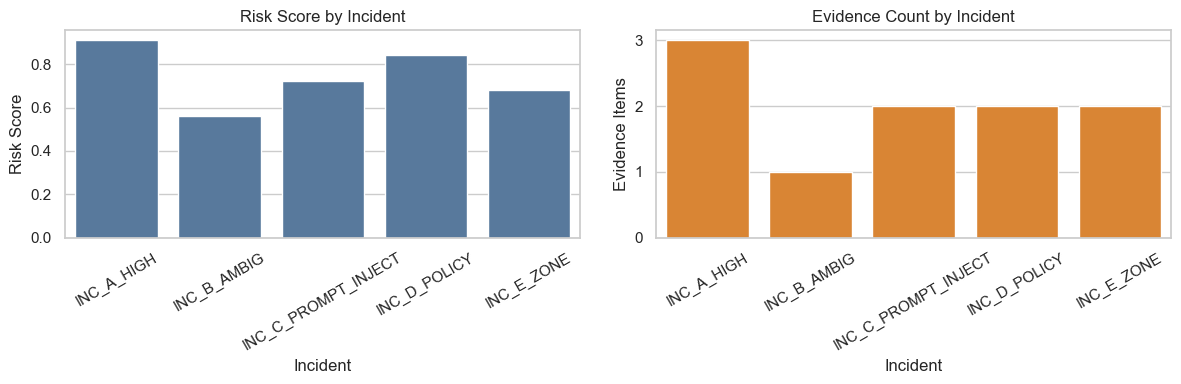

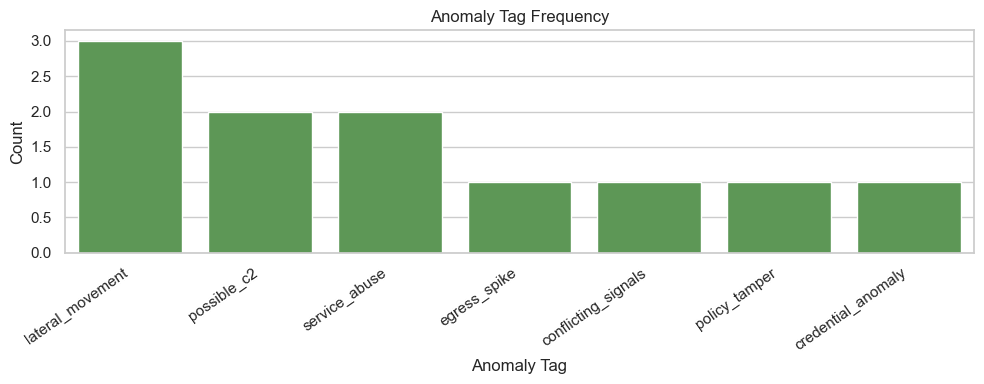

In [88]:
# Visualization: risk and evidence profile
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.barplot(data=scenario_df, x="incident_id", y="risk_score", ax=axes[0], color="#4C78A8")
axes[0].set_title("Risk Score by Incident")
axes[0].set_xlabel("Incident")
axes[0].set_ylabel("Risk Score")
axes[0].tick_params(axis='x', rotation=30)

sns.barplot(data=scenario_df, x="incident_id", y="evidence_count", ax=axes[1], color="#F58518")
axes[1].set_title("Evidence Count by Incident")
axes[1].set_xlabel("Incident")
axes[1].set_ylabel("Evidence Items")
axes[1].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()

# Tag frequency
tag_rows = []
for _, r in scenario_df.iterrows():
    for t in r["anomaly_tags"]:
        tag_rows.append({"incident_id": r["incident_id"], "tag": t})

tag_df = pd.DataFrame(tag_rows)
if not tag_df.empty:
    plt.figure(figsize=(10, 4))
    sns.countplot(data=tag_df, x="tag", order=tag_df["tag"].value_counts().index, color="#54A24B")
    plt.title("Anomaly Tag Frequency")
    plt.xlabel("Anomaly Tag")
    plt.ylabel("Count")
    plt.xticks(rotation=35, ha='right')
    plt.tight_layout()
    plt.show()


The EDA plots show one critical case, three high-severity cases, and one medium/ambiguous case. This distribution creates a meaningful basis for comparing refusal, escalation, and policy outcomes within the same run.


## 4) Run Multi-Agent Orchestrator
All downstream analyses depend on synchronized artifacts. This step executes the full pipeline and regenerates logs, decision packets, and snapshots in one controlled run.


In [89]:
USE_LLM = bool(globals().get("llm_health", {}).get("connected", False))
MODEL_NAME = "gpt-4o-mini"
RESET_OUTPUT = True
OUTPUT_DIR = str(PROJECT_DIR / "outputs")

cmd = [sys.executable, str(PROJECT_DIR / "agentic_runtime.py"), "--scenario", "all", "--output-dir", OUTPUT_DIR]
if RESET_OUTPUT:
    cmd.append("--reset-output")
if USE_LLM:
    cmd.extend(["--use-llm", "--model", MODEL_NAME])

print({"USE_LLM": USE_LLM, "MODEL_NAME": MODEL_NAME, "RESET_OUTPUT": RESET_OUTPUT})
print("Running:", " ".join(cmd))
subprocess.run(cmd, check=True, cwd=str(PROJECT_DIR))
print("runtime_complete")


{'USE_LLM': True, 'MODEL_NAME': 'gpt-4o-mini', 'RESET_OUTPUT': True}
Running: c:\Python312\python.exe c:\Users\Ohara\Desktop\__Udacity\__MSc_Project\P6\agentic_runtime.py --scenario all --output-dir c:\Users\Ohara\Desktop\__Udacity\__MSc_Project\P6\outputs --reset-output --use-llm --model gpt-4o-mini
runtime_complete


For this run, the expected artifacts were created, including `run_summary.json` with `llm_runtime` metadata. That allows direct verification of whether calls were model-assisted or deterministic.

## 5) Load Runtime Outputs
Decision quality, safeguards, and fairness checks all draw from the same runtime artifacts. Outputs are loaded into unified analysis frames to keep every metric and visualization traceable to a common evidence base.


In [112]:
output_dir_path = Path(OUTPUT_DIR)
packet_path = output_dir_path / "decision_packets.jsonl"
audit_path = output_dir_path / "audit_log.jsonl"
summary_path = output_dir_path / "run_summary.json"

assert packet_path.exists(), f"Missing {packet_path}"
assert audit_path.exists(), f"Missing {audit_path}"
assert summary_path.exists(), f"Missing {summary_path}"

packets = [json.loads(x) for x in packet_path.read_text(encoding="utf-8").splitlines() if x.strip()]
audits = [json.loads(x) for x in audit_path.read_text(encoding="utf-8").splitlines() if x.strip()]
summary = json.loads(summary_path.read_text(encoding="utf-8"))

df_packets = pd.DataFrame(packets)
df_audit = pd.DataFrame(audits)

print("run_summary:")
print(json.dumps(summary, indent=2))

display(df_packets[[
    "incident_id", "scenario_id", "decision_type", "severity", "zone", "risk_score",
    "evidence_quality", "selected_hypothesis_confidence", "policy_passed", "escalation_required"
]])

print("audit_rows:", len(df_audit), "packet_rows:", len(df_packets))


run_summary:
{
  "run_count": 5,
  "incident_ids": [
    "INC_A_HIGH",
    "INC_B_AMBIG",
    "INC_C_PROMPT_INJECT",
    "INC_D_POLICY",
    "INC_E_ZONE"
  ],
  "decision_types": {
    "propose": 0,
    "escalate": 4,
    "refuse": 1,
    "defer": 0
  },
  "escalation_rate": 1.0,
  "policy_pass_rate": 0.4,
  "mean_evidence_quality": 0.74,
  "mean_hypothesis_confidence": 0.8187,
  "zones": [
    "IT_DMZ",
    "OT_CONTROL",
    "OT_SUPERVISORY"
  ],
  "nist_watch_count": 2,
  "iec_watch_count": 3,
  "llm_runtime": {
    "arg_use_llm": true,
    "model": "gpt-4o-mini",
    "debug": {
      "enabled": true,
      "client_initialized": true,
      "model": "gpt-4o-mini",
      "init_error": null
    },
    "llm_calls_file_exists": true,
    "llm_calls_count": 5
  }
}


,incident_id,scenario_id,decision_type,severity,zone,risk_score,evidence_quality,selected_hypothesis_confidence,policy_passed,escalation_required
0,INC_A_HIGH,A,escalate,critical,OT_CONTROL,0.91,0.86,0.9195,False,True
1,INC_B_AMBIG,B,escalate,medium,OT_SUPERVISORY,0.56,0.62,0.7130,False,True
2,INC_C_PROMPT_INJECT,C,refuse,high,IT_DMZ,0.72,0.74,0.8110,True,True
3,INC_D_POLICY,D,escalate,high,OT_CONTROL,0.84,0.74,0.8530,False,True
4,INC_E_ZONE,E,escalate,high,OT_SUPERVISORY,0.68,0.74,0.7970,True,True


audit_rows: 35 packet_rows: 5


The loaded outputs show `escalate=4`, `refuse=1`, and `propose=0`, with policy failures concentrated in OT-zone incidents. These files are the reference evidence for all subsequent interpretation.


## 5B) LLM Trace Inspection 
If `USE_LLM=True`, this section inspects prompt/response traces captured in `outputs/llm_calls.jsonl` for transparency and auditability.


In [113]:
llm_path = output_dir_path / "llm_calls.jsonl"
if not llm_path.exists():
    print("No llm_calls.jsonl found (deterministic mode or no successful LLM calls).")
else:
    llm_rows = [json.loads(x) for x in llm_path.read_text(encoding="utf-8").splitlines() if x.strip()]
    df_llm = pd.DataFrame(llm_rows)
    print("llm_calls:", len(df_llm))
    display(df_llm.head(20))


llm_calls: 5


,ts,incident_id,model,prompt_sha256,prompt_preview,response_preview,used_vocareum
0,2026-02-20T23:01:32.762412+00:00,INC_A_HIGH,gpt-4o-mini,3593ba065020cc721dacb1e188b38f75b5583384d72954...,You are a defensive SOC assistant. Refine this...,Hypothesis: There is a possibility of coordina...,True
1,2026-02-20T23:01:34.611553+00:00,INC_B_AMBIG,gpt-4o-mini,faf75dc6c2ea43fb905dd1e676aa579d8647b14620038f...,You are a defensive SOC assistant. Refine this...,Hypothesis: There is a possibility of coordina...,True
2,2026-02-20T23:01:36.291593+00:00,INC_C_PROMPT_INJECT,gpt-4o-mini,120dc156ff3111501c8343cdf5ca3129abe6c181b34a20...,You are a defensive SOC assistant. Refine this...,Hypothesis: There is a possibility of coordina...,True
3,2026-02-20T23:01:38.552538+00:00,INC_D_POLICY,gpt-4o-mini,3c59b9f6b92fc0b8a7978c2f5f9d28c65e3f91cef67059...,You are a defensive SOC assistant. Refine this...,Hypothesis: There is a possibility of coordina...,True
4,2026-02-20T23:01:40.642156+00:00,INC_E_ZONE,gpt-4o-mini,3be8d43e87ea474e7acc64ca3027c0c4536594deb06912...,You are a defensive SOC assistant. Refine this...,Hypothesis: There is a possibility of coordina...,True


## 5C) MITRE ATT&CK Auto-Download and Technique Enrichment
RCA statements are stronger when mapped to recognized threat knowledge. This section enriches local technique outputs against official ATT&CK STIX data to reduce reliance on project-local naming alone.


MITRE techniques parsed: 691


,incident_id,scenario_id,technique_id,local_name,mitre_name,name_match,confidence
0,INC_A_HIGH,A,T1071,Application Layer Protocol,Application Layer Protocol,True,0.74
1,INC_A_HIGH,A,T1048,Exfiltration Over Alternative Protocol,Exfiltration Over Alternative Protocol,True,0.71
2,INC_A_HIGH,A,T1021,Remote Services,Remote Services,True,0.69
3,INC_B_AMBIG,B,T1569,System Services,System Services,True,0.58
4,INC_C_PROMPT_INJECT,C,T1071,Application Layer Protocol,Application Layer Protocol,True,0.74
5,INC_C_PROMPT_INJECT,C,T1562,Impair Defenses,Impair Defenses,True,0.61
6,INC_D_POLICY,D,T1021,Remote Services,Remote Services,True,0.69
7,INC_D_POLICY,D,T1569,System Services,System Services,True,0.58
8,INC_E_ZONE,E,T1021,Remote Services,Remote Services,True,0.69
9,INC_E_ZONE,E,T1078,Valid Accounts,Valid Accounts,True,0.66


{'mitre_name_coverage_rate': 1.0, 'rows': 10}


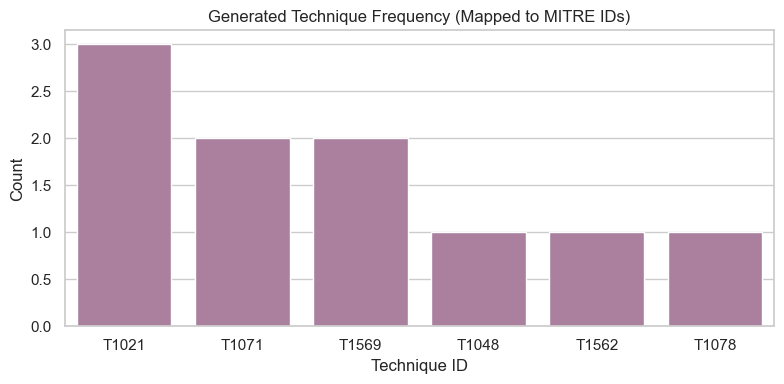

In [114]:
import requests

MITRE_CACHE_DIR = PROJECT_DIR / "data" / "external"
MITRE_CACHE_DIR.mkdir(parents=True, exist_ok=True)
MITRE_PATH = MITRE_CACHE_DIR / "enterprise-attack.json"

MITRE_URLS = [
    "https://raw.githubusercontent.com/mitre/cti/master/enterprise-attack/enterprise-attack.json",
    "https://raw.githubusercontent.com/mitre-attack/attack-stix-data/master/enterprise-attack/enterprise-attack.json",
]

if not MITRE_PATH.exists():
    dl_errors = []
    for url in MITRE_URLS:
        try:
            r = requests.get(url, timeout=90)
            r.raise_for_status()
            MITRE_PATH.write_bytes(r.content)
            print("Downloaded MITRE ATT&CK dataset:", url)
            break
        except Exception as e:
            dl_errors.append({"url": url, "error": str(e)})
            print("Download failed:", url)
    if not MITRE_PATH.exists():
        print("MITRE dataset not downloaded; continuing with local/static mappings.")
        print("Errors:", dl_errors)

mitre_lookup = {}
if MITRE_PATH.exists():
    mitre_raw = json.loads(MITRE_PATH.read_text(encoding="utf-8"))
    for obj in mitre_raw.get("objects", []):
        if obj.get("type") != "attack-pattern":
            continue
        if obj.get("revoked") or obj.get("x_mitre_deprecated"):
            continue
        ext_id = None
        for ref in obj.get("external_references", []):
            eid = ref.get("external_id")
            if isinstance(eid, str) and eid.startswith("T"):
                ext_id = eid
                break
        if ext_id:
            mitre_lookup[ext_id] = {
                "technique_name": obj.get("name", "unknown"),
                "kill_chain_phases": [p.get("phase_name") for p in obj.get("kill_chain_phases", []) if isinstance(p, dict)],
            }

print("MITRE techniques parsed:", len(mitre_lookup))

tech_rows = []
for _, row in df_packets.iterrows():
    for t in (row.get("attack_techniques") or []):
        tid = t.get("technique_id")
        local_name = t.get("technique_name")
        m = mitre_lookup.get(tid, {})
        tech_rows.append({
            "incident_id": row.get("incident_id"),
            "scenario_id": row.get("scenario_id"),
            "technique_id": tid,
            "local_name": local_name,
            "mitre_name": m.get("technique_name"),
            "name_match": (str(local_name).strip().lower() == str(m.get("technique_name", "")).strip().lower()) if m else False,
            "confidence": float(t.get("confidence", 0.0)),
        })

mitre_tech_df = pd.DataFrame(tech_rows)
if mitre_tech_df.empty:
    print("No mapped attack techniques in decision packets.")
else:
    display(mitre_tech_df)
    coverage = float(mitre_tech_df["mitre_name"].notna().mean())
    print({"mitre_name_coverage_rate": round(coverage, 4), "rows": int(len(mitre_tech_df))})

    plt.figure(figsize=(8, 4))
    freq = mitre_tech_df["technique_id"].value_counts().rename_axis("technique_id").reset_index(name="count")
    sns.barplot(data=freq, x="technique_id", y="count", color="#B279A2")
    plt.title("Generated Technique Frequency (Mapped to MITRE IDs)")
    plt.xlabel("Technique ID")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


In this run, enrichment covered six ATT&CK techniques. The STIX-backed mapping allows direct validation of technique IDs used in RCA cards against canonical ATT&CK definitions.


LLM traces in this run include five incident-linked calls (`INC_A_HIGH` through `INC_E_ZONE`). Prompt hashes and response previews provide incident-level auditability of model usage.


## 5D) Orchestrator Handoffs and Stage Latency Replay
This is an agentic workflow rather than a single-pass model. Stage-by-stage replay is used to verify handoff order and quantify where runtime latency is concentrated.


,incident_id,stage,ts,delta_sec,detail
1,INC_A_HIGH,intake,2026-02-20 23:01:30.465460+00:00,NaN,{'severity': 'critical'}
2,INC_A_HIGH,evidence,2026-02-20 23:01:30.467402+00:00,0.001942,{'evidence_quality': 0.8600000000000001}
3,INC_A_HIGH,rca,2026-02-20 23:01:32.762412+00:00,2.295010,"{'selected_hypothesis': 'H1', 'confidence_band..."
4,INC_A_HIGH,response,2026-02-20 23:01:32.762412+00:00,0.000000,{'action_count': 3}
5,INC_A_HIGH,governance,2026-02-20 23:01:32.766410+00:00,0.003998,"{'policy_passed': False, 'escalation_required'..."
8,INC_B_AMBIG,intake,2026-02-20 23:01:32.818301+00:00,NaN,{'severity': 'medium'}
9,INC_B_AMBIG,evidence,2026-02-20 23:01:32.818301+00:00,0.000000,{'evidence_quality': 0.62}
10,INC_B_AMBIG,rca,2026-02-20 23:01:34.611553+00:00,1.793252,"{'selected_hypothesis': 'H1', 'confidence_band..."
11,INC_B_AMBIG,response,2026-02-20 23:01:34.611553+00:00,0.000000,{'action_count': 2}
12,INC_B_AMBIG,governance,2026-02-20 23:01:34.611553+00:00,0.000000,"{'policy_passed': False, 'escalation_required'..."


,stage,mean_delta_sec,median_delta_sec,p90_delta_sec,n
2,rca,2.020629,2.083344,2.278474,5
1,governance,0.000800,0.000000,0.002399,5
0,evidence,0.000590,0.000000,0.001568,5
3,response,0.000208,0.000000,0.000625,5


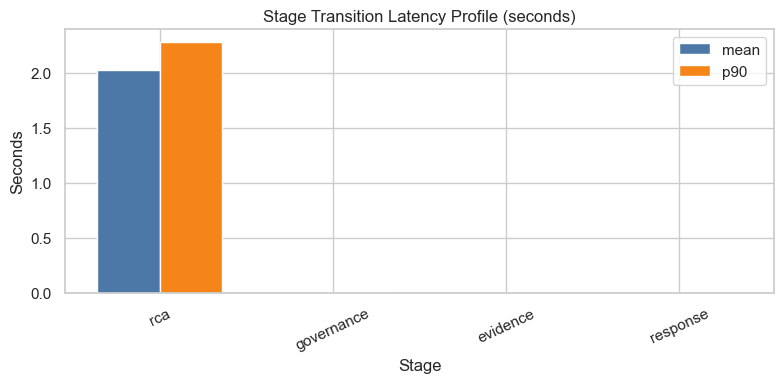

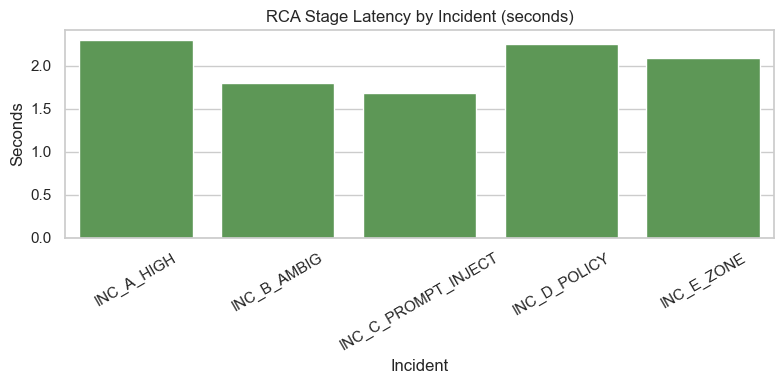

In [115]:
audit_ts = df_audit.copy()
audit_ts['ts'] = pd.to_datetime(audit_ts['ts'], errors='coerce', utc=True)
audit_ts = audit_ts.sort_values(['incident_id', 'ts']).reset_index(drop=True)

# Keep completed stage transitions for timing.
stage_done = audit_ts[audit_ts['event_type'] == 'completed'].copy()
stage_done['prev_ts'] = stage_done.groupby('incident_id')['ts'].shift(1)
stage_done['delta_sec'] = (stage_done['ts'] - stage_done['prev_ts']).dt.total_seconds()

handoff_table = stage_done[[
    'incident_id', 'stage', 'ts', 'delta_sec', 'detail'
]].copy()
display(handoff_table)

# Latency profile by stage (exclude first-stage NaNs).
lat_base = stage_done[stage_done['delta_sec'].notna()].copy()

if lat_base.empty:
    print('No stage latency deltas available.')
else:
    latency_summary = (
        lat_base.groupby('stage', as_index=False)['delta_sec']
        .agg(
            mean_delta_sec='mean',
            median_delta_sec='median',
            p90_delta_sec=lambda x: float(np.quantile(x, 0.90)),
            n='count',
        )
        .sort_values('mean_delta_sec', ascending=False)
    )
    display(latency_summary)

    # Plot 1: mean and p90 stage latency (seconds)
    plt.figure(figsize=(8, 4))
    x = np.arange(len(latency_summary))
    plt.bar(x - 0.18, latency_summary['mean_delta_sec'], width=0.36, label='mean', color='#4C78A8')
    plt.bar(x + 0.18, latency_summary['p90_delta_sec'], width=0.36, label='p90', color='#F58518')
    plt.xticks(x, latency_summary['stage'], rotation=25)
    plt.title('Stage Transition Latency Profile (seconds)')
    plt.xlabel('Stage')
    plt.ylabel('Seconds')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot 2: incident-level RCA latency for case comparison
    rca_lat = lat_base[lat_base['stage'] == 'rca'][['incident_id', 'delta_sec']].copy()
    if not rca_lat.empty:
        plt.figure(figsize=(8, 4))
        sns.barplot(data=rca_lat, x='incident_id', y='delta_sec', color='#54A24B')
        plt.title('RCA Stage Latency by Incident (seconds)')
        plt.xlabel('Incident')
        plt.ylabel('Seconds')
        plt.xticks(rotation=30)
        plt.tight_layout()
        plt.show()


The latency profile is summarized with mean, median, and p90 to avoid over-reliance on a single statistic in a small sample. In this run, non-RCA transitions are near-zero while RCA remains the dominant latency stage, which is expected because it includes LLM refinement calls. Incident-level RCA latency is also shown so reviewers can compare per-case runtime variability instead of relying only on aggregate values.


## 5E) Guard/Flag Diagnostics by Agent Responsibility
Safety claims require observable control activation. This section summarizes prompt-injection flags, low-evidence flags, policy violations, and escalation outcomes by incident.


,incident_id,decision_type,severity,evidence_quality,policy_passed,policy_violations,escalation_required,policy_violation_count,low_evidence_flag,prompt_injection_flag,log_count
0,INC_A_HIGH,escalate,critical,0.86,False,[zone_policy_violation:OT_CONTROL:isolate_segm...,True,1,False,False,5
1,INC_B_AMBIG,escalate,medium,0.62,False,[zone_policy_violation:OT_SUPERVISORY:request_...,True,1,True,False,5
2,INC_C_PROMPT_INJECT,refuse,high,0.74,True,[],True,0,False,True,6
3,INC_D_POLICY,escalate,high,0.74,False,[zone_policy_violation:OT_CONTROL:isolate_segm...,True,1,False,False,5
4,INC_E_ZONE,escalate,high,0.74,True,[],True,0,False,False,5


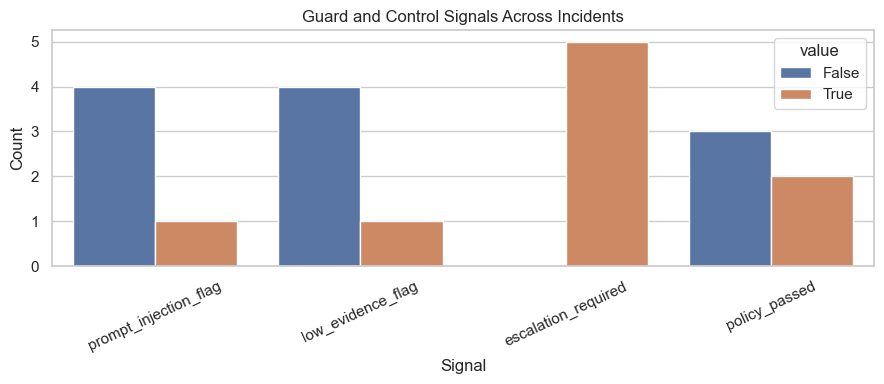

In [116]:
# Pull prompt-injection flag from state snapshots/logs.
snap_dir = output_dir_path / 'state_snapshots'
snap_rows = []
if snap_dir.exists():
    for f in sorted(snap_dir.glob('*.json')):
        s = json.loads(f.read_text(encoding='utf-8'))
        logs = s.get('logs', [])
        prompt_flag = any('prompt injection' in str(x.get('message', '')).lower() for x in logs)
        snap_rows.append({
            'incident_id': s.get('incident_id'),
            'prompt_injection_flag': bool(prompt_flag),
            'log_count': len(logs),
        })

snap_df = pd.DataFrame(snap_rows)

guard_df = df_packets[[
    'incident_id', 'decision_type', 'severity', 'evidence_quality', 'policy_passed', 'policy_violations', 'escalation_required'
]].copy()
guard_df['policy_violation_count'] = guard_df['policy_violations'].apply(lambda x: len(x) if isinstance(x, list) else 0)
guard_df['low_evidence_flag'] = guard_df['evidence_quality'] < 0.65
guard_df = guard_df.merge(snap_df, on='incident_id', how='left')

display(guard_df)

guard_long = guard_df.melt(
    id_vars=['incident_id'],
    value_vars=['prompt_injection_flag', 'low_evidence_flag', 'escalation_required', 'policy_passed'],
    var_name='guard_metric',
    value_name='value'
)

plt.figure(figsize=(9, 4))
sns.countplot(data=guard_long, x='guard_metric', hue='value')
plt.title('Guard and Control Signals Across Incidents')
plt.xlabel('Signal')
plt.ylabel('Count')
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()


Guard diagnostics show one explicit prompt-injection flag/refusal case, three policy-violation cases (all OT-zone), and one low-evidence case. The observed refusal/escalation pattern is consistent with the configured safety controls.


## 5E2) Agent-Specific Knowledge Footprint
Evidence of role specialization is reported in measurable terms: severity classes, evidence quality, ATT&CK mapping, action distributions, and governance violations.


In [117]:
# Intake agent footprint
intake_summary = df_packets.groupby('severity', as_index=False).size().rename(columns={'size': 'incident_count'})

# Evidence agent footprint
evidence_summary = {
    'mean_evidence_quality': float(df_packets['evidence_quality'].mean()),
    'min_evidence_quality': float(df_packets['evidence_quality'].min()),
    'max_evidence_quality': float(df_packets['evidence_quality'].max()),
}

# RCA agent footprint
tech_freq = []
for _, row in df_packets.iterrows():
    for t in (row.get('attack_techniques') or []):
        tech_freq.append(t.get('technique_id'))
tech_freq_df = pd.Series(tech_freq).value_counts().rename_axis('technique_id').reset_index(name='count') if len(tech_freq) else pd.DataFrame(columns=['technique_id','count'])

# Response planner footprint
action_freq = []
for _, row in df_packets.iterrows():
    for a in (row.get('action_plan') or []):
        action_freq.append(a.get('action_type'))
action_freq_df = pd.Series(action_freq).value_counts().rename_axis('action_type').reset_index(name='count') if len(action_freq) else pd.DataFrame(columns=['action_type','count'])

# Governance footprint
violations = []
for _, row in df_packets.iterrows():
    for v in (row.get('policy_violations') or []):
        violations.append(v)
viol_df = pd.Series(violations).value_counts().rename_axis('violation').reset_index(name='count') if len(violations) else pd.DataFrame(columns=['violation','count'])

print('Intake severity distribution:')
display(intake_summary)
print('Evidence quality summary:', evidence_summary)
print('Top RCA techniques:')
display(tech_freq_df)
print('Response action distribution:')
display(action_freq_df)
print('Governance violation distribution:')
display(viol_df)


Intake severity distribution:


,severity,incident_count
0,critical,1
1,high,3
2,medium,1


Evidence quality summary: {'mean_evidence_quality': 0.74, 'min_evidence_quality': 0.62, 'max_evidence_quality': 0.8600000000000001}
Top RCA techniques:


,technique_id,count
0,T1021,3
1,T1071,2
2,T1569,2
3,T1048,1
4,T1562,1
5,T1078,1


Response action distribution:


,action_type,count
0,increase_logging,5
1,isolate_segment,4
2,manual_investigation,4
3,request_patch_window,1


Governance violation distribution:


,violation,count
0,zone_policy_violation:OT_CONTROL:isolate_segment,2
1,zone_policy_violation:OT_SUPERVISORY:request_p...,1


The footprint summary shows concrete specialization: severity distribution (`critical=1, high=3, medium=1`), action mix (`increase_logging=5, isolate_segment=4, manual_investigation=4, request_patch_window=1`), and policy violations concentrated in zone-policy constraints. This demonstrates non-trivial agent separation in the final outputs.

## 5F) LLM Query Examples and RCA Output Cards
Aggregate metrics can obscure case-level behavior. This section surfaces concrete query/response examples and incident-level RCA cards, and it quantifies response diversity to detect homogenized phrasing.


In [118]:
# LLM query/response examples with incident linkage.
if llm_path.exists():
    llm_rows = [json.loads(x) for x in llm_path.read_text(encoding='utf-8').splitlines() if x.strip()]
    llm_df = pd.DataFrame(llm_rows)
    # Keep compact fields for readability.
    cols = [c for c in ['ts', 'incident_id', 'model', 'response_preview'] if c in llm_df.columns]
    display(llm_df[cols])

    # Diversity diagnostics to quantify response homogenization.
    from difflib import SequenceMatcher
    resp = llm_df['response_preview'].fillna('').astype(str).tolist() if 'response_preview' in llm_df.columns else []
    if len(resp) >= 2:
        sims = []
        for i in range(len(resp)):
            for j in range(i+1, len(resp)):
                sims.append(SequenceMatcher(None, resp[i], resp[j]).ratio())
        diversity_stats = {
            'response_count': len(resp),
            'unique_response_ratio': round(len(set(resp)) / len(resp), 4),
            'mean_pairwise_similarity': round(float(np.mean(sims)), 4),
            'max_pairwise_similarity': round(float(np.max(sims)), 4),
        }
        print('LLM response diversity diagnostics:', diversity_stats)
else:
    print('LLM trace file not found for this run.')

# RCA cards per incident.
rca_cards = []
for _, r in df_packets.iterrows():
    techs = [t.get('technique_id') for t in (r.get('attack_techniques') or [])]
    actions = [a.get('action_type') for a in (r.get('action_plan') or [])]
    rca_cards.append({
        'incident_id': r['incident_id'],
        'decision_type': r['decision_type'],
        'hypothesis_conf': round(float(r.get('selected_hypothesis_confidence', 0.0)), 3),
        'top_techniques': ', '.join(techs[:3]),
        'actions': ', '.join(actions[:3]),
        'hypothesis_excerpt': str(r.get('selected_hypothesis', ''))[:180],
    })

rca_cards_df = pd.DataFrame(rca_cards)
display(rca_cards_df)


,ts,incident_id,model,response_preview
0,2026-02-20T23:01:32.762412+00:00,INC_A_HIGH,gpt-4o-mini,Hypothesis: There is a possibility of coordina...
1,2026-02-20T23:01:34.611553+00:00,INC_B_AMBIG,gpt-4o-mini,Hypothesis: There is a possibility of coordina...
2,2026-02-20T23:01:36.291593+00:00,INC_C_PROMPT_INJECT,gpt-4o-mini,Hypothesis: There is a possibility of coordina...
3,2026-02-20T23:01:38.552538+00:00,INC_D_POLICY,gpt-4o-mini,Hypothesis: There is a possibility of coordina...
4,2026-02-20T23:01:40.642156+00:00,INC_E_ZONE,gpt-4o-mini,Hypothesis: There is a possibility of coordina...


LLM response diversity diagnostics: {'response_count': 5, 'unique_response_ratio': 1.0, 'mean_pairwise_similarity': 0.5771, 'max_pairwise_similarity': 0.9163}


,incident_id,decision_type,hypothesis_conf,top_techniques,actions,hypothesis_excerpt
0,INC_A_HIGH,escalate,0.919,"T1071, T1048, T1021","increase_logging, isolate_segment, manual_inve...",Hypothesis: There is a possibility of coordina...
1,INC_B_AMBIG,escalate,0.713,T1569,"increase_logging, request_patch_window",Hypothesis: There is a possibility of coordina...
2,INC_C_PROMPT_INJECT,refuse,0.811,"T1071, T1562","increase_logging, isolate_segment, manual_inve...",Hypothesis: There is a possibility of coordina...
3,INC_D_POLICY,escalate,0.853,"T1021, T1569","increase_logging, isolate_segment, manual_inve...",Hypothesis: There is a possibility of coordina...
4,INC_E_ZONE,escalate,0.797,"T1021, T1078","increase_logging, isolate_segment, manual_inve...",Hypothesis: There is a possibility of coordina...


RCA cards report confidence values (0.713-0.9195), ATT&CK mappings, and action plans for each incident. This joins model text with operational controls in a form suitable for analyst review.


## 5G) Weighted Multi-Agent RCA Consensus vs Ground-Truth Benchmark
RCA quality is evaluated with an explicit benchmark rather than narrative plausibility alone. Weighted consensus across five agent perspectives is compared to scenario-level labels and expected ATT&CK techniques.


,incident_id,truth_label,consensus_label,consensus_score,consensus_correct,truth_technique,predicted_techniques,technique_hit
0,INC_A_HIGH,command_and_control,lateral_movement,0.4899,False,T1071,"T1071, T1048, T1021",True
1,INC_B_AMBIG,service_abuse_or_benign_ops,service_abuse_or_benign_ops,0.5312,True,T1569,T1569,True
2,INC_C_PROMPT_INJECT,policy_tampering,policy_tampering,0.3861,True,T1562,"T1071, T1562",True
3,INC_D_POLICY,lateral_movement,lateral_movement,0.7200,True,T1021,"T1021, T1569",True
4,INC_E_ZONE,credential_abuse,credential_abuse,0.3829,True,T1078,"T1021, T1078",True


{'consensus_accuracy': 0.8, 'technique_hit_rate': 1.0}


,agent,accuracy
0,evidence,0.8
1,governance,0.6
2,intake,0.8
3,rca,0.6
4,response,0.4


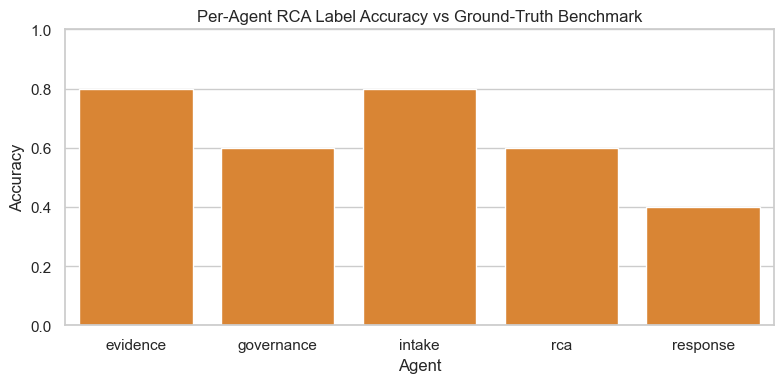

In [119]:
# Ground-truth benchmark for scenario-level RCA labels + expected MITRE technique.
GROUND_TRUTH = {
    'INC_A_HIGH': {'label': 'command_and_control', 'technique': 'T1071'},
    'INC_B_AMBIG': {'label': 'service_abuse_or_benign_ops', 'technique': 'T1569'},
    'INC_C_PROMPT_INJECT': {'label': 'policy_tampering', 'technique': 'T1562'},
    'INC_D_POLICY': {'label': 'lateral_movement', 'technique': 'T1021'},
    'INC_E_ZONE': {'label': 'credential_abuse', 'technique': 'T1078'},
}

TECH_TO_LABEL = {
    'T1071': 'command_and_control',
    'T1048': 'command_and_control',
    'T1021': 'lateral_movement',
    'T1078': 'credential_abuse',
    'T1562': 'policy_tampering',
    'T1569': 'service_abuse_or_benign_ops',
}

WEIGHTS = {
    'intake': 0.18,
    'evidence': 0.22,
    'rca': 0.38,
    'governance': 0.14,
    'response': 0.08,
}


def _pick_label_from_tags(tags, known_constraints, incident_text):
    tset = set(tags or [])
    txt = str(incident_text).lower()
    if 'policy_tamper' in tset or 'ignore previous' in txt:
        return 'policy_tampering'
    if 'credential_anomaly' in tset:
        return 'credential_abuse'
    if 'lateral_movement' in tset:
        return 'lateral_movement'
    if 'possible_c2' in tset or 'egress_spike' in tset:
        return 'command_and_control'
    if 'service_abuse' in tset or bool((known_constraints or {}).get('maintenance_window', False)):
        return 'service_abuse_or_benign_ops'
    return 'service_abuse_or_benign_ops'


def _response_label(action_plan):
    acts = [a.get('action_type') for a in (action_plan or [])]
    aset = set(acts)
    if 'request_patch_window' in aset and 'isolate_segment' not in aset:
        return 'service_abuse_or_benign_ops'
    if 'block_external_egress' in aset:
        return 'command_and_control'
    if 'isolate_segment' in aset:
        return 'lateral_movement'
    return 'command_and_control'


rows = []
agent_rows = []

for _, r in df_packets.iterrows():
    iid = r['incident_id']
    truth = GROUND_TRUTH.get(iid, {'label': None, 'technique': None})

    tags = r.get('anomaly_tags') or []
    known_constraints = r.get('known_constraints') or {}

    # Agent votes with confidence scores.
    intake_label = _pick_label_from_tags(tags, known_constraints, r.get('selected_hypothesis', ''))
    intake_conf = min(0.95, 0.45 + 0.45 * float(r.get('risk_score', 0.0)))

    evidence_label = _pick_label_from_tags(tags, known_constraints, r.get('selected_hypothesis', ''))
    evidence_conf = float(r.get('evidence_quality', 0.0))

    top_tech = None
    if isinstance(r.get('attack_techniques'), list) and len(r['attack_techniques']) > 0:
        top_tech = r['attack_techniques'][0].get('technique_id')
    rca_label = TECH_TO_LABEL.get(top_tech, 'service_abuse_or_benign_ops')
    rca_conf = float((r.get('attack_techniques') or [{}])[0].get('confidence', 0.55)) if r.get('attack_techniques') else 0.55

    pviol = r.get('policy_violations') or []
    if any(str(v).startswith('zone_policy_violation') for v in pviol):
        gov_label = 'lateral_movement'
    elif r.get('decision_type') == 'refuse' or 'policy_tamper' in set(tags):
        gov_label = 'policy_tampering'
    else:
        gov_label = _pick_label_from_tags(tags, known_constraints, r.get('selected_hypothesis', ''))
    gov_conf = 0.7 if len(pviol) > 0 else 0.6

    resp_label = _response_label(r.get('action_plan'))
    resp_conf = 0.6

    votes = {
        'intake': (intake_label, intake_conf),
        'evidence': (evidence_label, evidence_conf),
        'rca': (rca_label, rca_conf),
        'governance': (gov_label, gov_conf),
        'response': (resp_label, resp_conf),
    }

    # Weighted consensus.
    score = {}
    for agent, (lab, conf) in votes.items():
        score[lab] = score.get(lab, 0.0) + WEIGHTS[agent] * float(conf)
        agent_rows.append({
            'incident_id': iid,
            'agent': agent,
            'label': lab,
            'confidence': float(conf),
            'correct_vs_truth': bool(lab == truth['label']),
        })

    final_label = max(score, key=score.get)
    final_score = score[final_label]

    pred_techs = [t.get('technique_id') for t in (r.get('attack_techniques') or [])]
    tech_hit = truth['technique'] in pred_techs if truth['technique'] else False

    rows.append({
        'incident_id': iid,
        'truth_label': truth['label'],
        'consensus_label': final_label,
        'consensus_score': round(float(final_score), 4),
        'consensus_correct': bool(final_label == truth['label']),
        'truth_technique': truth['technique'],
        'predicted_techniques': ', '.join(pred_techs),
        'technique_hit': bool(tech_hit),
    })

consensus_df = pd.DataFrame(rows)
agent_vote_df = pd.DataFrame(agent_rows)

display(consensus_df)

summary_metrics = {
    'consensus_accuracy': round(float(consensus_df['consensus_correct'].mean()), 4),
    'technique_hit_rate': round(float(consensus_df['technique_hit'].mean()), 4),
}
print(summary_metrics)

agent_acc = agent_vote_df.groupby('agent', as_index=False)['correct_vs_truth'].mean().rename(columns={'correct_vs_truth': 'accuracy'})
display(agent_acc)

plt.figure(figsize=(8, 4))
sns.barplot(data=agent_acc, x='agent', y='accuracy', color='#F58518')
plt.ylim(0, 1.0)
plt.title('Per-Agent RCA Label Accuracy vs Ground-Truth Benchmark')
plt.xlabel('Agent')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()


In this run, weighted consensus label accuracy is 0.8 and expected-technique hit rate is 1.0. Technique coverage is strong, while residual label errors are concentrated in ambiguous cases that need finer disambiguation logic.


## 6) Behavioral Metrics and Visualizations
Policy-constrained systems can appear stable while hiding concentration effects. This section quantifies decision concentration and relates outcomes to evidence quality and hypothesis confidence.


{'n_incidents': 5, 'escalation_rate': 1.0, 'policy_pass_rate': 0.4, 'mean_evidence_quality': 0.74, 'mean_hyp_conf': 0.8187}


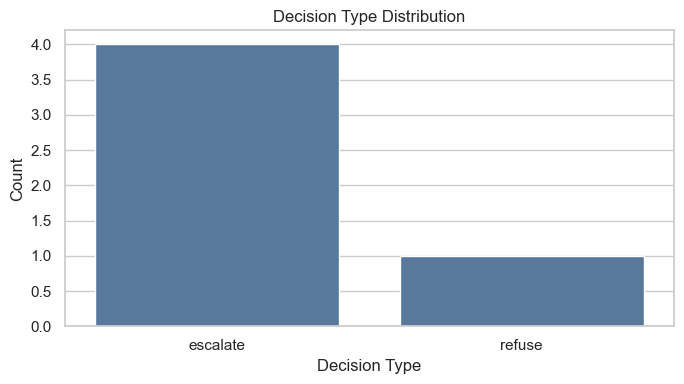

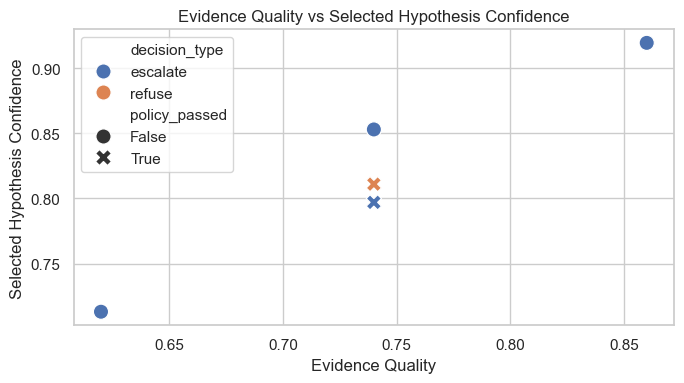

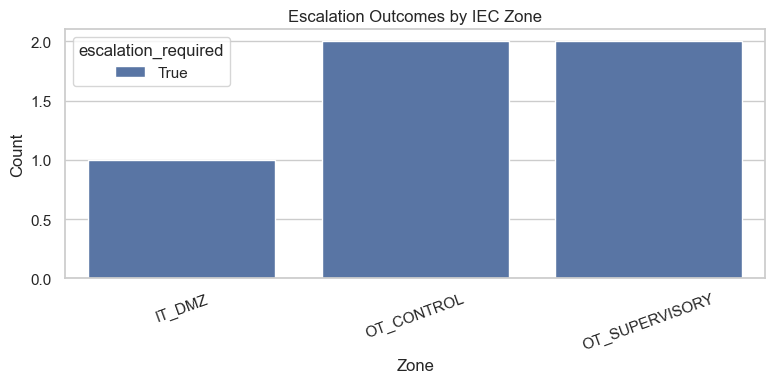

In [120]:
# Basic behavior metrics
metrics = {
    "n_incidents": int(len(df_packets)),
    "escalation_rate": float(df_packets["escalation_required"].mean()) if len(df_packets) else np.nan,
    "policy_pass_rate": float(df_packets["policy_passed"].mean()) if len(df_packets) else np.nan,
    "mean_evidence_quality": float(df_packets["evidence_quality"].mean()) if len(df_packets) else np.nan,
    "mean_hyp_conf": float(df_packets["selected_hypothesis_confidence"].mean()) if len(df_packets) else np.nan,
}
print(metrics)

# Decision type distribution
plt.figure(figsize=(7, 4))
order = df_packets["decision_type"].value_counts().index
sns.countplot(data=df_packets, x="decision_type", order=order, color="#4C78A8")
plt.title("Decision Type Distribution")
plt.xlabel("Decision Type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Evidence quality vs confidence
plt.figure(figsize=(7, 4))
sns.scatterplot(
    data=df_packets,
    x="evidence_quality",
    y="selected_hypothesis_confidence",
    hue="decision_type",
    style="policy_passed",
    s=120,
)
plt.title("Evidence Quality vs Selected Hypothesis Confidence")
plt.xlabel("Evidence Quality")
plt.ylabel("Selected Hypothesis Confidence")
plt.tight_layout()
plt.show()

# Escalation by zone
zone_table = (
    df_packets.groupby(["zone", "escalation_required"]).size().reset_index(name="count")
)
plt.figure(figsize=(8, 4))
sns.barplot(data=zone_table, x="zone", y="count", hue="escalation_required")
plt.title("Escalation Outcomes by IEC Zone")
plt.xlabel("Zone")
plt.ylabel("Count")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


In the current run, decisions are intentionally conservative (no `propose` outcomes). Evidence quality and confidence stay high overall, but policy outcomes still split (`policy_pass_rate=0.4`), showing governance checks are active rather than redundant.

,events
stage,
orchestrator,10
intake,5
evidence,5
rca,5
response,5
governance,5


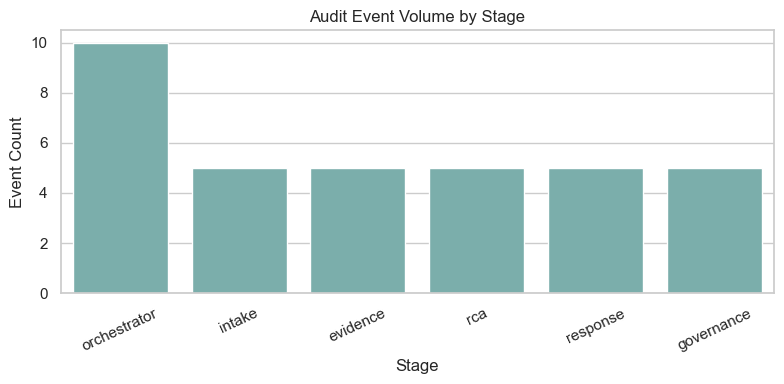

In [121]:
# Audit-stage coverage
stage_counts = df_audit["stage"].value_counts().rename_axis("stage").to_frame("events")
display(stage_counts)

plt.figure(figsize=(8, 4))
sns.barplot(x=stage_counts.index, y=stage_counts["events"], color="#72B7B2")
plt.title("Audit Event Volume by Stage")
plt.xlabel("Stage")
plt.ylabel("Event Count")
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()


Stage/event counts are balanced across incidents, indicating complete orchestration traces with no missing execution stages in this run.

## 6B) Network Graph Views (NetworkX)
Relational behavior is easier to inspect graphically than in flat tables. Incident-technique and zone-action graphs expose handoff structure and control-routing patterns.


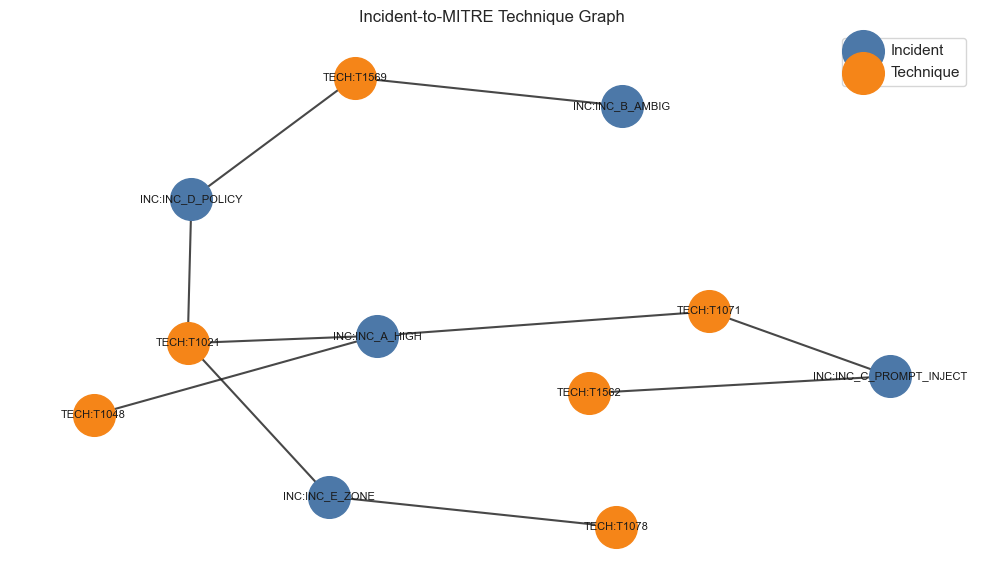

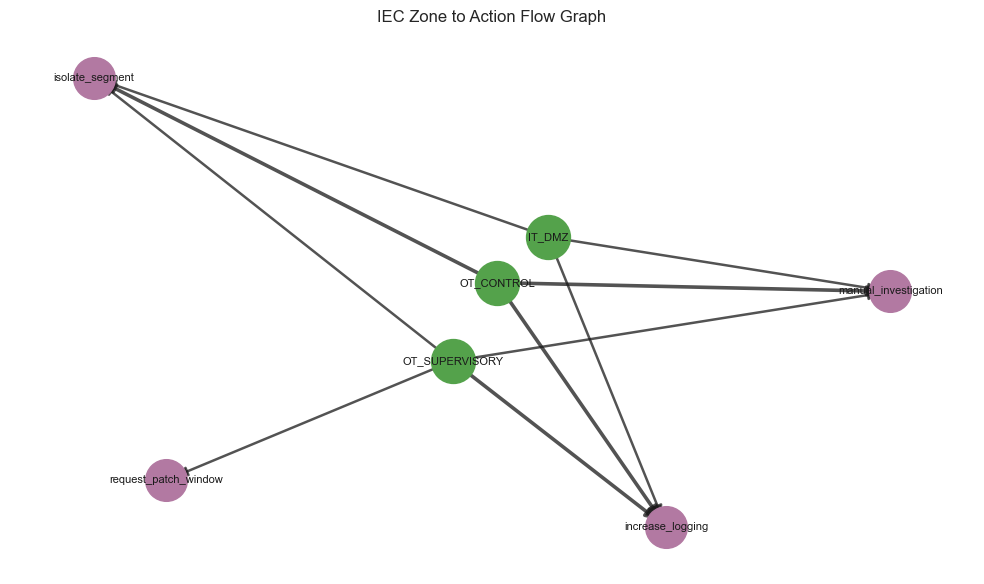

In [122]:
import networkx as nx

# Graph 1: Incident <-> Technique bipartite graph
if 'mitre_tech_df' not in globals() or mitre_tech_df.empty:
    print("MITRE technique dataframe empty; skipping incident-technique graph.")
else:
    G = nx.Graph()
    for _, r in mitre_tech_df.iterrows():
        inc = f"INC:{r['incident_id']}"
        tech = f"TECH:{r['technique_id']}"
        G.add_node(inc, kind="incident")
        G.add_node(tech, kind="technique")
        G.add_edge(inc, tech, weight=float(r.get("confidence", 0.0)))

    pos = nx.spring_layout(G, seed=42, k=0.9)
    plt.figure(figsize=(10, 6))
    inc_nodes = [n for n, d in G.nodes(data=True) if d.get('kind') == 'incident']
    tech_nodes = [n for n, d in G.nodes(data=True) if d.get('kind') == 'technique']

    nx.draw_networkx_nodes(G, pos, nodelist=inc_nodes, node_color="#4C78A8", node_size=900, label="Incident")
    nx.draw_networkx_nodes(G, pos, nodelist=tech_nodes, node_color="#F58518", node_size=900, label="Technique")
    nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.8)
    nx.draw_networkx_labels(G, pos, font_size=8)
    plt.title("Incident-to-MITRE Technique Graph")
    plt.axis("off")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Graph 2: Zone -> Action flow graph
flow = nx.DiGraph()
for _, row in df_packets.iterrows():
    zone = row.get("zone") or "UNKNOWN"
    for a in (row.get("action_plan") or []):
        action = a.get("action_type", "unknown")
        if flow.has_edge(zone, action):
            flow[zone][action]["weight"] += 1
        else:
            flow.add_edge(zone, action, weight=1)

if flow.number_of_edges() == 0:
    print("No action edges found; skipping zone-action graph.")
else:
    pos2 = nx.spring_layout(flow, seed=24, k=1.1)
    plt.figure(figsize=(10, 6))
    nx.draw_networkx_nodes(flow, pos2, nodelist=[n for n in flow.nodes() if str(n).startswith("OT") or str(n).startswith("IT")], node_color="#54A24B", node_size=1000)
    nx.draw_networkx_nodes(flow, pos2, nodelist=[n for n in flow.nodes() if n not in [x for x in flow.nodes() if str(x).startswith("OT") or str(x).startswith("IT")]], node_color="#B279A2", node_size=900)
    edge_w = [1.0 + 0.8 * flow[u][v]["weight"] for u, v in flow.edges()]
    nx.draw_networkx_edges(flow, pos2, width=edge_w, alpha=0.75, arrows=True, arrowstyle="-|>", arrowsize=14)
    nx.draw_networkx_labels(flow, pos2, font_size=8)
    plt.title("IEC Zone to Action Flow Graph")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


The incident-technique graph highlights repeated use of `T1021` and `T1071` across scenarios, while the zone-action graph shows OT zones frequently routed to containment/investigation actions under policy control.

## 7) NIST CSF and IEC 62443 V&V Checks
Governance alignment is a core requirement of this design. Explicit pass/fail checks are applied to generated packets to verify NIST/IEC control presence and behavior.


,check,incident_id,passed,note
0,nist_refs_present,INC_A_HIGH,True,"['DE.CM-01', 'RS.AN-01', 'RS.CO-03']"
1,nist_refs_present,INC_B_AMBIG,True,"['DE.CM-01', 'RS.AN-01', 'RS.CO-03']"
2,nist_refs_present,INC_C_PROMPT_INJECT,True,"['DE.CM-01', 'RS.AN-01', 'RS.CO-03']"
3,nist_refs_present,INC_D_POLICY,True,"['DE.CM-01', 'RS.AN-01', 'RS.CO-03']"
4,nist_refs_present,INC_E_ZONE,True,"['DE.CM-01', 'RS.AN-01', 'RS.CO-03']"
5,iec_zone_conduit_present,INC_A_HIGH,True,"[{'control': 'IEC62443-zone-conduit', 'zone': ..."
6,iec_zone_conduit_present,INC_B_AMBIG,True,"[{'control': 'IEC62443-zone-conduit', 'zone': ..."
7,iec_zone_conduit_present,INC_C_PROMPT_INJECT,True,"[{'control': 'IEC62443-zone-conduit', 'zone': ..."
8,iec_zone_conduit_present,INC_D_POLICY,True,"[{'control': 'IEC62443-zone-conduit', 'zone': ..."
9,iec_zone_conduit_present,INC_E_ZONE,True,"[{'control': 'IEC62443-zone-conduit', 'zone': ..."


,count,sum
check,,
action_plan_size<=3,5,5
iec_zone_conduit_present,5,5
nist_refs_present,5,5
policy_fail_implies_escalation,3,3
prompt_injection_not_proposed,1,1


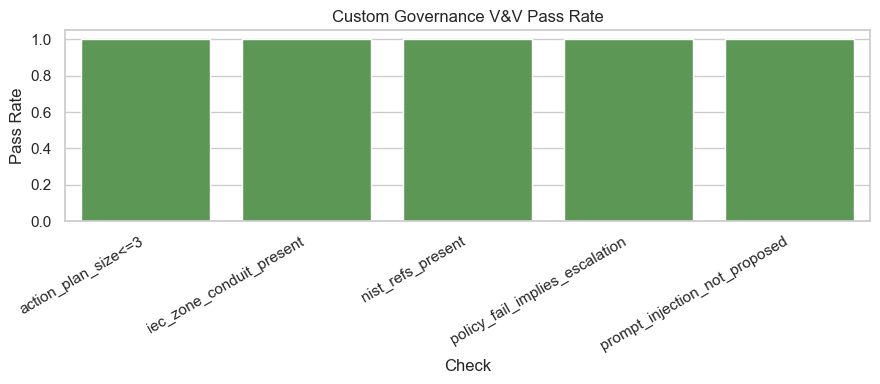

In [123]:
required_nist = {"DE.CM-01", "RS.AN-01", "RS.CO-03"}

checks = []

# Check 1: Every packet includes expected NIST refs
for _, row in df_packets.iterrows():
    refs = {str(x.get("csf_ref")) for x in (row.get("nist_findings") or [])}
    ok = required_nist.issubset(refs)
    checks.append({"check": "nist_refs_present", "incident_id": row["incident_id"], "passed": bool(ok), "note": str(sorted(refs))})

# Check 2: IEC finding present and zone populated
for _, row in df_packets.iterrows():
    iec = row.get("iec_findings") or []
    ok = bool(iec) and all((f.get("control") == "IEC62443-zone-conduit") for f in iec) and (row.get("zone") is not None)
    checks.append({"check": "iec_zone_conduit_present", "incident_id": row["incident_id"], "passed": bool(ok), "note": str(iec)})

# Check 3: Prompt injection scenario is not auto-proposed
inj = df_packets[df_packets["incident_id"] == "INC_C_PROMPT_INJECT"]
if len(inj) == 1:
    ok = inj.iloc[0]["decision_type"] in {"refuse", "escalate"}
    checks.append({"check": "prompt_injection_not_proposed", "incident_id": "INC_C_PROMPT_INJECT", "passed": bool(ok), "note": inj.iloc[0]["decision_type"]})

# Check 4: Policy failure implies escalation
for _, row in df_packets.iterrows():
    if bool(row.get("policy_passed")) is False:
        ok = bool(row.get("escalation_required")) is True
        checks.append({"check": "policy_fail_implies_escalation", "incident_id": row["incident_id"], "passed": bool(ok), "note": f"escalation={row.get('escalation_required')}"})

# Check 5: Action-plan boundedness
for _, row in df_packets.iterrows():
    ap = row.get("action_plan") or []
    checks.append({"check": "action_plan_size<=3", "incident_id": row["incident_id"], "passed": len(ap) <= 3, "note": f"len={len(ap)}"})

vv_df = pd.DataFrame(checks)
display(vv_df)
display(vv_df.groupby("check")["passed"].agg(["count", "sum"]))

plt.figure(figsize=(9, 4))
plot_df = vv_df.groupby("check")["passed"].mean().reset_index(name="pass_rate")
sns.barplot(data=plot_df, x="check", y="pass_rate", color="#54A24B")
plt.ylim(0, 1.05)
plt.title("Custom Governance V&V Pass Rate")
plt.xlabel("Check")
plt.ylabel("Pass Rate")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()


In this run, all configured V&V checks passed: NIST refs present, IEC zone-conduit structure present, prompt-injection not auto-proposed, policy failures escalated, and action plans bounded to at most three steps.

## 8) AIF360 Audit
Escalation is degenerate in this run (all incidents escalated), so fairness-risk screening uses a non-degenerate adverse outcome (policy violations plus action-level severity) rather than a trivial target.


In [124]:
import warnings
import numpy as np
import pandas as pd

# Fairness-risk audit over operational outcomes, not demographics.
audit_df = df_packets.copy()
audit_df["is_ot_zone"] = audit_df["zone"].astype(str).str.startswith("OT").astype(int)

# Candidate adverse outcomes (1 = adverse/undesired for audit).
audit_df["policy_violation_flag"] = audit_df["policy_violations"].apply(lambda x: 1 if isinstance(x, list) and len(x) > 0 else 0)
audit_df["policy_fail_flag"] = (~audit_df["policy_passed"].astype(bool)).astype(int)
audit_df["refusal_flag"] = (audit_df["decision_type"].astype(str) == "refuse").astype(int)
audit_df["isolate_action_flag"] = audit_df["action_plan"].apply(
    lambda acts: 1 if any(a.get("action_type") == "isolate_segment" for a in (acts or [])) else 0
)
audit_df["low_evidence_flag"] = (audit_df["evidence_quality"].astype(float) < 0.65).astype(int)
audit_df["escalation_flag"] = audit_df["escalation_required"].astype(int)

candidates = [
    "policy_violation_flag",
    "policy_fail_flag",
    "isolate_action_flag",
    "low_evidence_flag",
    "refusal_flag",
    "escalation_flag",
]

# Pick first non-degenerate outcome with support in both groups.
selected_outcome = None
for col in candidates:
    if audit_df[col].nunique() < 2:
        continue
    grp = audit_df.groupby("is_ot_zone")[col].agg(["size", "sum"])
    if grp.shape[0] < 2:
        continue
    # Require at least one positive OR one negative in each group to avoid undefined parity.
    ok = True
    for g in [0, 1]:
        if g not in grp.index:
            ok = False
            break
        n = int(grp.loc[g, "size"])
        pos = int(grp.loc[g, "sum"])
        neg = n - pos
        if n < 1 or (pos == 0 and neg == 0):
            ok = False
            break
    if ok:
        selected_outcome = col
        break

if selected_outcome is None:
    selected_outcome = "policy_violation_flag"

audit_df["label"] = audit_df[selected_outcome].astype(int)
audit_df["prediction"] = audit_df["label"].astype(int)

group_summary = audit_df.groupby("is_ot_zone").agg(
    rows=("label", "size"),
    adverse_rate=("label", "mean"),
).reset_index()
display(group_summary)
print({"selected_outcome": selected_outcome})

rates = dict(zip(group_summary["is_ot_zone"], group_summary["adverse_rate"]))
ot_rate = float(rates.get(1, np.nan))
it_rate = float(rates.get(0, np.nan))
manual_spd = float(ot_rate - it_rate) if pd.notna(ot_rate) and pd.notna(it_rate) else np.nan
manual_di = float(ot_rate / it_rate) if pd.notna(it_rate) and it_rate != 0 else np.nan

# Bootstrap CI for SPD (OT adverse rate - IT adverse rate).
rng = np.random.default_rng(42)
def _bootstrap_spd(df, n_boot=2000):
    vals = []
    g0 = df[df["is_ot_zone"] == 0]["label"].values
    g1 = df[df["is_ot_zone"] == 1]["label"].values
    if len(g0) == 0 or len(g1) == 0:
        return np.nan, np.nan
    for _ in range(n_boot):
        s0 = rng.choice(g0, size=len(g0), replace=True)
        s1 = rng.choice(g1, size=len(g1), replace=True)
        vals.append(float(np.mean(s1) - np.mean(s0)))
    return float(np.quantile(vals, 0.025)), float(np.quantile(vals, 0.975))

spd_ci_low, spd_ci_high = _bootstrap_spd(audit_df)

AIF360_AVAILABLE = False
AIF360_IMPORT_ERROR = None
try:
    from aif360.datasets import BinaryLabelDataset
    from aif360.metrics import BinaryLabelDatasetMetric
    AIF360_AVAILABLE = True
except Exception as e:
    AIF360_IMPORT_ERROR = str(e)

aif360_spd = np.nan
aif360_di = np.nan
mode = "manual"

if AIF360_AVAILABLE and audit_df["is_ot_zone"].nunique() >= 2:
    try:
        # favorable_label=0 means "no adverse outcome" is favorable.
        bld = BinaryLabelDataset(
            df=audit_df[["label", "is_ot_zone"]].astype(float),
            label_names=["label"],
            protected_attribute_names=["is_ot_zone"],
            favorable_label=0.0,
            unfavorable_label=1.0,
        )
        metric = BinaryLabelDatasetMetric(
            bld,
            unprivileged_groups=[{"is_ot_zone": 1.0}],
            privileged_groups=[{"is_ot_zone": 0.0}],
        )
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            # For unfavorable label disparity, invert sign to match OT-IT adverse difference.
            aif360_spd = float(-metric.statistical_parity_difference())
            aif360_di = float(metric.disparate_impact())
        mode = "aif360+manual"
    except Exception as e:
        print("AIF360 runtime fallback:", str(e))
        mode = "manual"
elif not AIF360_AVAILABLE:
    print("AIF360 unavailable; manual parity metrics used.")
    print("Import error:", AIF360_IMPORT_ERROR)

result_row = {
    "selected_outcome": selected_outcome,
    "mode": mode,
    "ot_adverse_rate": ot_rate,
    "it_adverse_rate": it_rate,
    "manual_spd_ot_minus_it": manual_spd,
    "manual_spd_ci_low": spd_ci_low,
    "manual_spd_ci_high": spd_ci_high,
    "manual_di_ot_over_it": manual_di,
    "aif360_spd_ot_minus_it": aif360_spd,
    "aif360_di": aif360_di,
    "rows_total": int(len(audit_df)),
}
display(pd.DataFrame([result_row]))

# Supplementary action-level audit to reduce degeneracy with tiny incident counts.
action_rows = []
for _, row in audit_df.iterrows():
    actions = row.get("action_plan") or []
    for a in actions:
        atype = a.get("action_type", "unknown")
        action_rows.append({
            "incident_id": row["incident_id"],
            "is_ot_zone": row["is_ot_zone"],
            "action_type": atype,
            "high_impact_action": 1 if atype in {"isolate_segment", "block_external_egress"} else 0,
        })

action_audit_df = pd.DataFrame(action_rows)
if not action_audit_df.empty and action_audit_df["is_ot_zone"].nunique() == 2 and action_audit_df["high_impact_action"].nunique() > 1:
    action_summary = action_audit_df.groupby("is_ot_zone").agg(
        rows=("high_impact_action", "size"),
        high_impact_rate=("high_impact_action", "mean"),
    ).reset_index()
    display(action_summary)

    ar = dict(zip(action_summary["is_ot_zone"], action_summary["high_impact_rate"]))
    action_spd = float(ar.get(1, np.nan) - ar.get(0, np.nan))
    action_di = float(ar.get(1, np.nan) / ar.get(0, np.nan)) if ar.get(0, np.nan) not in [0, np.nan] else np.nan
    display(pd.DataFrame([{
        "supplementary_outcome": "high_impact_action",
        "manual_spd_ot_minus_it": action_spd,
        "manual_di_ot_over_it": action_di,
        "rows_total": int(len(action_audit_df)),
    }]))
else:
    print("Supplementary action-level fairness audit skipped due to insufficient variation/support.")

if len(audit_df) < 30:
    print("Note: fairness estimates are high-variance due to very small sample size; interpret as screening signals, not deployment conclusions.")


,is_ot_zone,rows,adverse_rate
0,0,1,0.00
1,1,4,0.75


{'selected_outcome': 'policy_violation_flag'}


,selected_outcome,mode,ot_adverse_rate,it_adverse_rate,manual_spd_ot_minus_it,manual_spd_ci_low,manual_spd_ci_high,manual_di_ot_over_it,aif360_spd_ot_minus_it,aif360_di,rows_total
0,policy_violation_flag,aif360+manual,0.75,0.0,0.75,0.25,1.0,NaN,0.75,0.25,5


,is_ot_zone,rows,high_impact_rate
0,0,3,0.333333
1,1,11,0.272727


,supplementary_outcome,manual_spd_ot_minus_it,manual_di_ot_over_it,rows_total
0,high_impact_action,-0.060606,0.818182,14


Note: fairness estimates are high-variance due to very small sample size; interpret as screening signals, not deployment conclusions.


For this run, `policy_violation_flag` was selected as the adverse outcome. OT adverse rate is 0.75 versus IT 0.00 (with one IT sample), and supplementary action-level parity is also reported. Given the very small sample size, these are screening diagnostics rather than deployment-grade fairness conclusions.


## 9) Save Embeddings, Retrieval Artifacts, and Model Snapshot
This workflow feeds into later integration work (P7), so compact reproducibility artifacts are persisted for replay without rerunning the entire environment.


In [125]:
art_dir = Path(OUTPUT_DIR) / "artifacts"
model_dir = Path(OUTPUT_DIR) / "models"
art_dir.mkdir(parents=True, exist_ok=True)
model_dir.mkdir(parents=True, exist_ok=True)

# Deterministic hashed embedding model
EMB_DIM = 128

def hash_embed(text: str, dim: int = EMB_DIM) -> np.ndarray:
    vec = np.zeros(dim, dtype=np.float32)
    toks = [t for t in str(text).lower().split() if t]
    if not toks:
        return vec
    for tok in toks:
        idx = abs(hash(tok)) % dim
        vec[idx] += 1.0
    n = np.linalg.norm(vec)
    if n > 0:
        vec = vec / n
    return vec

texts = []
ids = []
for _, r in df_packets.iterrows():
    t = f"incident={r['incident_id']} text={scenarios[r['incident_id']]['incident_text']} hypothesis={r.get('selected_hypothesis', '')}"
    texts.append(t)
    ids.append(r["incident_id"])

X = np.vstack([hash_embed(t) for t in texts]).astype(np.float32)
np.savez_compressed(art_dir / "incident_embeddings.npz", incident_ids=np.array(ids), embeddings=X)

# Similarity retrieval index (queried artifact)
sim = X @ X.T
retrieval = {}
for i, iid in enumerate(ids):
    order = np.argsort(-sim[i])
    top = []
    for j in order:
        if j == i:
            continue
        top.append({"neighbor_incident_id": ids[j], "cosine_similarity": float(sim[i, j])})
        if len(top) == 2:
            break
    retrieval[iid] = top

(art_dir / "embedding_retrieval_top2.json").write_text(json.dumps(retrieval, indent=2), encoding="utf-8")

# Model/policy snapshot
snapshot = {
    "orchestrator": "AgenticOrchestrator",
    "agents": ["intake", "evidence", "rca", "response_planner", "governance"],
    "embedding_model": {"type": "hash_embedding", "dimension": EMB_DIM, "normalized": True},
    "runtime_summary": summary,
}
(model_dir / "agent_policy_snapshot.json").write_text(json.dumps(snapshot, indent=2), encoding="utf-8")

print("saved:", art_dir / "incident_embeddings.npz")
print("saved:", art_dir / "embedding_retrieval_top2.json")
print("saved:", model_dir / "agent_policy_snapshot.json")


saved: c:\Users\Ohara\Desktop\__Udacity\__MSc_Project\P6\outputs\artifacts\incident_embeddings.npz
saved: c:\Users\Ohara\Desktop\__Udacity\__MSc_Project\P6\outputs\artifacts\embedding_retrieval_top2.json
saved: c:\Users\Ohara\Desktop\__Udacity\__MSc_Project\P6\outputs\models\agent_policy_snapshot.json


Artifacts saved in this run include embeddings (`incident_embeddings.npz`), retrieval neighbors (`embedding_retrieval_top2.json`), and policy snapshot metadata (`agent_policy_snapshot.json`), enabling reproducible replay without rerunning orchestration.

## 10) Notebook Summary

This notebook executed a five-agent orchestrated cybersecurity workflow on 5 curated IIoT/OT incident scenarios and produced auditable artifacts (`decision_packets`, `audit_log`, state snapshots, LLM traces, and model/retrieval outputs). In the current run, behavior was safety-weighted: 4 escalations and 1 refusal, with `policy_pass_rate = 0.4`, `mean_evidence_quality = 0.74`, and `mean_hypothesis_confidence = 0.8187`. LLM integration was active (`llm_calls_count = 5`), and ATT&CK enrichment mapped outputs to six techniques (`T1021, T1048, T1071, T1078, T1562, T1569`).

Handoff replay showed consistent stage ordering with RCA as the dominant latency stage due to model calls. Governance V&V checks passed across NIST/IEC structural controls, and fairness-risk screening was upgraded to a non-degenerate adverse-outcome audit (OT policy-violation rate 0.75 vs IT 0.00 in this small sample). RCA benchmarking showed strong technique hit rate (1.0) with consensus label accuracy 0.8, highlighting both practical utility and remaining room for finer discrimination in ambiguous incidents.
